# MAE345 HW4: Coding
## Alkin Kaz (due 10/12/2022)

# Lab 4: Rapidly-Exploring Random Trees (60 Pts)

In this homework, we will implement the Rapidly-Exploring Random Tree algorithm discussed in class. If you need a reference outside of the class notes, you can consult [Lavalle's textbook](http://planning.cs.uiuc.edu), or [his 1998 paper on the topic](http://msl.cs.illinois.edu/~lavalle/papers/Lav98c.pdf) --- both of which are very accessible. First, let's begin with some imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

## A Note on Terminology

The literature on motion planning sometimes means different things by the terms "configuration space" and "free space". In this assignment, we define the _configuration space_ to be the set of robot configurations the robot can be placed in when we ignore obstacles. This is the definition we used in class. In addition, we define the _free space_ to bet the set of configurations that do not place the robot in intersection with one or more obstacles.

To keep things simple, we will assume that the robot is a point that can move in the plane. The configuration space is thus (a subset of) $\mathbb{R}^2$. 

## Problem 1: Checking for Free Configurations (10 Pts)

In this part, we will write functions for checking if configurations and lines between configurations are in the free space. 

Configurations are represented as `np.ndarray` types with dimension `(2,)`. That is, they are a vector where the first entry is the $x$ coordinate and the second entry is the $y$ coordinate. Edges of the graph, which in this assignment are straight line segments, are represented as a tuple containing the two endpoints of the line segment.

All the obstacles that we work with are circles. These are represented in our code as a tuple, where the first entry is an `np.ndarray` containing the center of the circle and the second entry is the radius of the circle.

Fill out the following two functions in adherence to the behavior specified in their docstrings. Note that there are multiple ways to test if a line intersects a circle. You are free to use any method that you wish. These Wikipedia articles may be useful:
- [Distance from a Point to a Line](https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line)
- [Line-Sphere Intersection](https://en.wikipedia.org/wiki/Line–sphere_intersection)

Throughout this assignment, you are free to use any of the functions in NumPy (especially its `linalg` module) to fill out the code.

In [2]:
def conf_free(q: np.ndarray, obstacles: List[Tuple[np.ndarray, float]]) -> bool:
    """
    Check if a configuration is in the free space.
    
    This function checks if the configuration q lies outside of all the obstacles in the connfiguration space.
    
    @param q: An np.ndarray of shape (2,) representing a robot configuration.
    @param obstacles: A list of obstacles. Each obstacle is a tuple of the form (center, radius) representing a circle.
    @return: True if the configuration is in the free space, i.e. it lies outside of all the circles in `obstacles`. 
             Otherwise return False.
    """

    # The conf is in free space if it is away from all obstacle centers
    # by their respective radii
    for obstacle in obstacles:
        if np.linalg.norm(q - obstacle[0]) <= obstacle[1]:
            return False

    return True

def edge_free(edge: Tuple[np.ndarray, np.ndarray], obstacles: List[Tuple[np.ndarray, float]]) -> bool:
    """
    Check if a graph edge is in the free space.
    
    This function checks if a graph edge, i.e. a line segment specified as two end points, lies entirely outside of
    every obstacle in the configuration space.
    
    @param edge: A tuple containing the two segment endpoints.
    @param obstacles: A list of obstacles as described in `config_free`.
    @return: True if the edge is in the free space, i.e. it lies entirely outside of all the circles in `obstacles`. 
             Otherwise return False.
    """

    # The edge is in free space if it the closest point to the respective obstacle center
    # (i.e. the cross-section of the line with the perpendicular from that center) is
    # away by the respective radius, for all obstacles

    edge_start = np.append(edge[0], 0)
    edge_end = np.append(edge[1], 0)

    for obstacle in obstacles:
        # check the markdown cell below for derivation.
        ctr = np.append(obstacle[0], 0)
        h = np.linalg.norm(np.cross(ctr - edge_start, edge_end - edge_start))\
            / np.linalg.norm(edge_end - edge_start)

        if h <= obstacle[1]:
            return False

    return True

### Derivation of the Point-Line Segment Distance Formula

Noticing that we can expand planar points to the 3-dimensional space by adding a null third dimension, consider the point $P_0 \in \mathbb{R}^3$ that we would like to find the shortest distance to the line segment defined by the end-points $P_1, P_2 \in \mathbb{R}^3$. We know that the shortest distance would be achieved by the perpendicular dropped from $P_0$ - let us define the length of that perpendicuar to be $h$. Defining the angle between the vectors $P_0 - P_1$ and $P_2 - P_1$ to be $\alpha$, the perpendicularity implies

$$ h = \left\lVert P_0 - P_1\right\rVert \sin \alpha$$

We also know that the angle $\alpha$ can be determined from the norm of the cross-product

$$ \left\lVert (P_0 - P_1)\times (P_2 - P_1) \right\rVert = \left\lVert P_0 - P_1\right\rVert \left\lVert P_2 - P_1\right\rVert \sin \alpha = \left\lVert P_2 - P_1\right\rVert h \implies$$

$$ h = \frac{\left\lVert (P_0 - P_1)\times (P_2 - P_1) \right\rVert}{\left\lVert P_2 - P_1\right\rVert}$$

## Problem 2: Sampling the Configuration Space (10 Pts)

The next function we need is one to randomly sample the configuration space. Our configuration space is assumed to be a rectangle with a specified height and width. You should use [np.random.rand](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.rand.html) to sample random numbers.

In [3]:
def random_conf(width: float, height: float) -> np.ndarray:
    """
    Sample a random configuration from the configuration space.
    
    This function draws a uniformly random configuration from the configuration space rectangle. The configuration 
    does not necessarily have to reside in the free space.
    
    @param width: The configuration space width.
    @param height: The configuration space height.
    @return: A random configuration uniformily distributed across the configuration space.
    """
    return np.array([width, height]) * np.random.rand(2)

## Problem 3: The `Extend` Function (10 Pts)

We're almost ready to write our RRT function. The last thing we need are functions that find the nearest vertex to our sampled vertex and the function that creates the new extension vertex in the direction of the sampled one.

We represent all the vertices in the graph as an `np.ndarray` with shape `(n, 2)` where `n` is the number of vertices. In this array, each row represents a vertex. This representation is very convient for how NumPy functions work with their arguments. Fill out the two following functions.

In [4]:
def nearest_vertex(conf: np.ndarray, vertices: np.ndarray) -> int:
    """
    Finds the nearest vertex to conf in the set of vertices.
    
    This function searches through the set of vertices and finds the one that is closest to 
    conf using the L2 norm (Euclidean distance).
    
    @param conf: The configuration we are trying to find the closest vertex to.
    @param vertices: The set of vertices represented as an np.array with shape (n, 2). Each row represents
                     a vertex.
    @return: The index (i.e. row of `vertices`) of the vertex that is closest to `conf`.
    """
    return np.argmin(np.linalg.norm(vertices-conf, axis=1))

def extend(origin: np.ndarray, target: np.ndarray, step_size: float=0.2) -> np.ndarray:
    """
    Extends the RRT at most a fixed distance toward the target configuration.
    
    Given a configuration in the RRT graph `origin`, this function returns a new configuration that takes a
    step of at most `step_size` towards the `target` configuration. That is, if the L2 distance between `origin`
    and `target` is less than `step_size`, return `target`. Otherwise, return the configuration on the line
    segment between `origin` and `target` that is `step_size` distance away from `origin`.
    
    @param origin: A vertex in the RRT graph to be extended.
    @param target: The vertex that is being extended towards.
    @param step_size: The maximum allowed distance the returned vertex can be from `origin`.
    
    @return: A new configuration that is as close to `target` as possible without being more than
            `step_size` away from `origin`.
    """
    if np.linalg.norm(target-origin) < step_size:
        return target
    else:
        # need to normalize the direction
        return origin + (target-origin)*step_size/np.linalg.norm(target-origin)
    pass

## Problem 4: Putting It All Together (30 Pts)

Finally, you have all the components you need to implement the RRT algorithm. The last thing that needs to be discussed is how to represent the graph that the RRT produces. Since this graph is a _tree_, a simple way is to represent the set of vertices as an `np.ndarray` of shape `(n, 2)` as discussed in the previous problem and then to maintain a list that specifies the parent vertex of each vertex. That is, to keep an `np.array` named `parents` such that if the parent of vertex `i` is `j`, then `parents[i] == j` is `True`.

After we construct the graph then, we can just select any vertex in the goal region and backtrack through this array to the start configuration to find a feasible trajectory. We will assign the parent of the starting configuration to be `-1`.

Fill out the main loop of the RRT algorithm and the backtracking function below.

In [5]:
def rrt(origin: np.ndarray, width: float, height: float, obstacles: List[Tuple[np.ndarray, float]],
        trials: int=1000, step_size: float=0.2) -> (np.ndarray, np.ndarray):
    """
    Explore a workspace using the RRT algorithm.
    
    This function builds an RRT using `trials` samples from the free space.
    
    @param origin: The starting configuration of the robot.
    @param width: The width of the configuration space.
    @param height: The height of the configuration space.
    @param obstacles: A list of circular obstacles.
    @param trials: The number of configurations to sample from the free space.
    @param step_size: The step_size to pass to `extend`.
    
    @return: A tuple (`vertices`, `parents`), where `vertices` is an (n, 2) `np.ndarray` where each row is a configuration vertex
             and `parents` is an array identifying the parent, i.e. `parents[i]` is the parent of the vertex in
             the `i`th row of `vertices.
    """
    num_verts = 1
    
    vertices = np.zeros((trials + 1, len(origin)))
    vertices[0, :] = origin
    
    parents = np.zeros(trials + 1, dtype=int)
    parents[0] = -1
    
    for trial in range(trials):
        #TODO: Fill this loop out for your assignment.
        conf_rand = random_conf(width, height)

        idx_conf_near = nearest_vertex(conf_rand, vertices[:num_verts])
        conf_near = vertices[idx_conf_near]

        conf_step = extend(conf_near, conf_rand, step_size)
        
        if conf_free(conf_step, obstacles) and edge_free((conf_near, conf_step), obstacles):
            
            vertices[num_verts] = conf_step
            parents[num_verts] = idx_conf_near
            num_verts += 1
    
    return vertices[:num_verts, :], parents[:num_verts]

def backtrack(index: int, parents: np.ndarray) -> List[int]:
    """
    Find the sequence of nodes from the origin of the graph to an index.
    
    This function returns a List of vertex indices going from the origin vertex to the vertex `index`.
    
    @param index: The vertex to find the path through the tree to.
    @param parents: The array of vertex parents as specified in the `rrt` function.
    
    @return: The list of vertex indicies such that specifies a path through the graph to `index`.
    """
    inv_path = [index]
    
    while inv_path[-1] != -1:
        inv_path.append(parents[inv_path[-1]])
    
    inv_path.reverse() 
    return inv_path[1:] # delete the init point

The next two cells run the RRT and plot the result. Feel free to adjust the `trials` and `step_size` parameters. You shouldn't modify the other code in these cells, and you should submit your notebook with a successful trajectory displayed. The goal region is shown as a circle with a green outline and center point on the plot. Obstacles are in blue.

In [6]:
width = 3
height = 4

obstacles = [(np.array([1, 1]), 0.25), (np.array([2, 2]), 0.25), (np.array([1, 3]), 0.3)]
goal = (np.array([2.5, 3.5]), 0.25)

origin = (0.1, 0.1)

vertices, parents = rrt(origin, width, height, obstacles)

index = nearest_vertex(goal[0], vertices)

if np.linalg.norm(vertices[index, :] - goal[0]) < 0.25:
    print('Path found!')
    path_verts = backtrack(index, parents)
else:
    print('No path found!')
    path_verts = []

Path found!


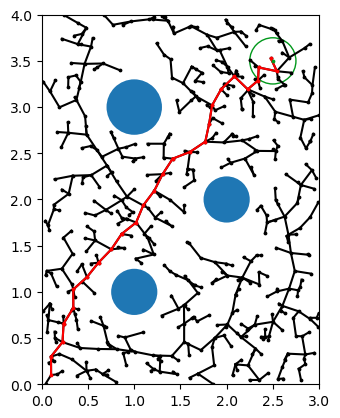

In [7]:
fig, ax = plt.subplots()

ax.set_xlim([0, width])
ax.set_ylim([0, height])
ax.set_aspect('equal')

for i in range(len(parents)):
    if parents[i] < 0:
        continue
    plt.plot([vertices[i, 0], vertices[parents[i], 0]], 
             [vertices[i, 1], vertices[parents[i], 1]], c='k')

for i in path_verts:
    if parents[i] < 0:
        continue
    plt.plot([vertices[i, 0], vertices[parents[i], 0]], 
             [vertices[i, 1], vertices[parents[i], 1]], c='r')    

for o in obstacles:
    ax.add_artist(plt.Circle(tuple(o[0]), o[1]))
    
ax.add_artist(plt.Circle(tuple(goal[0]), goal[1], ec=(0.004, 0.596, 0.105), fc=(1, 1, 1)))

plt.scatter([2.5], [3.5], zorder=3, c=np.array([[0.004, 0.596, 0.105]]), s=3)
plt.scatter(vertices[path_verts, 0], vertices[path_verts, 1], c=np.array([[1, 0, 0]]), s=3, zorder=2)
plt.scatter(vertices[1:, 0], vertices[1:, 1], c=np.array([[0, 0, 0]]), s=3)